In [1]:
import os
import urllib.request
import gzip
import shutil

def convert(imgf, labelf, outf, n):
    with open(imgf, "rb") as f, open(labelf, "rb") as l, open(outf, "w") as o:
        f.read(16)
        l.read(8)
        images = []

        for i in range(n):
            image = [int.from_bytes(l.read(1), byteorder='big')]
            image.extend([int.from_bytes(f.read(1), byteorder='big') for _ in range(28*28)])
            images.append(image)

        for image in images:
            o.write(",".join(map(str, image)) + "\n")

def init_mnist():
    if not os.path.exists("./dataset"):
        os.makedirs("./dataset")

    urls = {
        "train-images-idx3-ubyte" : "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
        "train-labels-idx1-ubyte" : "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte" : "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-labels-idx1-ubyte" : "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz"
    }

    for name, url in urls.items():
        file_path = f"./dataset/{name}"
        if not os.path.exists(file_path):
            gz_file_path = f"{file_path}.gz"
            print(f"Downloading {url}...")
            urllib.request.urlretrieve(url, gz_file_path)
            print(f"Extracting {gz_file_path}...")
            with gzip.open(gz_file_path, "rb") as f_in, open(file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
            os.remove(gz_file_path)  # Clean up the compressed file
            print(f"{file_path} ready.")

def generate_mnist_csv(train_file, test_file):
    init_mnist()
    if not os.path.exists(train_file):
        print(f"Converting training data to {train_file}...")
        convert("./dataset/train-images-idx3-ubyte", "./dataset/train-labels-idx1-ubyte",
            train_file, 60000)

    if not os.path.exists(test_file):
        print(f"Converting test data to {test_file}...")
        convert("./dataset/t10k-images-idx3-ubyte", "./dataset/t10k-labels-idx1-ubyte",
            test_file, 10000)

if __name__ == "__main__":
    generate_mnist_csv("./dataset/mnist_train.csv", "./dataset/mnist_test.csv")

Extracting ./dataset/train-images-idx3-ubyte.gz...
./dataset/train-images-idx3-ubyte ready.
Extracting ./dataset/train-labels-idx1-ubyte.gz...
./dataset/train-labels-idx1-ubyte ready.
Extracting ./dataset/t10k-images-idx3-ubyte.gz...
./dataset/t10k-images-idx3-ubyte ready.
Extracting ./dataset/t10k-labels-idx1-ubyte.gz...
./dataset/t10k-labels-idx1-ubyte ready.
Converting training data to ./dataset/mnist_train.csv...
Converting test data to ./dataset/mnist_test.csv...


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# from generate_mnist_csv import generate_mnist_csv

# Function to plot images
def plot_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

class ReadAndLoadMnistData:

    def __init__(self, train_file, test_file):
        self.train_file = train_file
        self.test_file = test_file
        self.train_df = None
        self.test_df = None

    def __enter__(self):
        # Ensuring files are generated
        generate_mnist_csv(self.train_file, self.test_file)

        # Load the CSV files into DataFrames
        self.train_df = pd.read_csv(self.train_file)
        self.test_df = pd.read_csv(self.test_file)

        return self

    def load_data(self):
        # Separate features and labels for both train and test datasets
        X_train = self.train_df.iloc[:, 1:]
        y_train = self.train_df.iloc[:, 0]
        X_test = self.test_df.iloc[:, 1:]
        y_test = self.test_df.iloc[:, 0]
        return X_train, y_train, X_test, y_test

    def __exit__(self, exc_type, exc_value, traceback):
        # Clean up DataFrames
        del self.train_df
        del self.test_df

        if exc_type:
            print(f"Exception has been handled: {exc_value}")
        else:
            print("No exception occurred")

        # Return True to suppress any exception
        return True

(59999, 784) (59999,) (9999, 784) (9999,)
   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.608  0.609  0.610  \
0  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.611  0.612  0.613  0.614  0.615  0.616  0.617  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 784 columns]


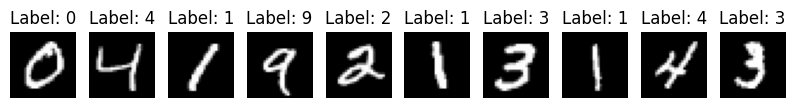

0    2
1    1
2    0
3    4
4    1
Name: 7, dtype: int64


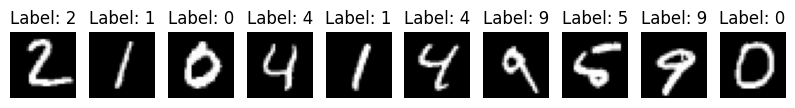

No exception occurred


In [3]:

if __name__ == "__main__":
    # Example usage
    train_file = "./dataset/mnist_train.csv"
    test_file = "./dataset/mnist_test.csv"

    with ReadAndLoadMnistData(train_file, test_file) as mnist_data:
        X_train, y_train, X_test, y_test = mnist_data.load_data()
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        print(X_train.head())
        plot_images(X_train.values, y_train.values)
        print(y_test.head())
        plot_images(X_test.values, y_test.values)

        # Normalize the images
        X_train = X_train.values / 255.0
        X_test = X_test.values / 255.0

        # Flatten the images
        X_train = X_train.reshape(-1, 28*28)
        X_test = X_test.reshape(-1, 28*28)

        # Todo: Train a model using the data

        # Toda: Hypwerparameter tuning

        # Todo: Cross-validation

        # Todo: Grid search

        # Todo: Evaluate the model

        # Todo: Make predictions

        # Todo: Plot the predictions

        # Todo: Save the model

        # Todo: Load the model

        # Todo: Make predictions using the loaded model

        # Todo: Plot the predictions